# Configs

In [5]:
from collections import defaultdict
import bamboolib as bam
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
from PIL import Image
import IPython.display

In [2]:
from gps_utils import *

In [3]:
from map_apis import *

In [4]:
from vision_utils import *

# File Preparation

In [15]:
metadata_file = '../../original_data/lsc22_medatada.csv'
movement_file = "files/lsc22_metadata_with_movement.csv"
# metadata_file = "../temp/filled_metadata.csv"
checkin_file = '../../original_data/checkins.json'
visual_file = '../../original_data/lsc22_visual_concepts.csv'
MONTHS = [f"2019{i:0>2}" for i in range(1, 13)] + [f"2020{i:0>2}" for i in range(1, 7)]
# MONTHS = ["201901"]

In [6]:
moves = {"I am sitting on an airplane": "Airplane",
         "I am in a car": "Car",
         "I am in an airport": "Inside",
         "I am walking outside or on the street": "Walking Outside",
         "I am on public transport": "Public Transport",
         "I am inside a building or a house": "Inside"}

In [7]:
prepared = True
if not prepared:
    metadata = pd.read_csv(metadata_file, sep=',', decimal='.')
    if len(MONTHS) == 1:
        metadata = metadata.loc[metadata['minute_id'].str.startswith(MONTHS[0], na=False)]
    metadata = metadata.reset_index()
    # Assign movement
    metadata["movement"] = [None for i in range(len(metadata))]
    metadata["movement_prob"] = [None for i in range(len(metadata))]
    metadata["inside"] = [None for i in range(len(metadata))]
    metadata["inside_prob"] = [None for i in range(len(metadata))]
    for i, row in metadata.iterrows():
        images = row["ImageID"]
        if isinstance(images, str):
            images = json.loads(images.replace("'", '"'))
            if images:
                image_features = get_stop_embeddings(images) 
            try:
                image_features = torch.tensor(image_features).cuda().float()
            except RuntimeError as e:
                continue
            movement, prob = movement_mode(list(moves.keys()), image_features)
            metadata.loc[i, "movement"] = moves[movement]
            metadata.loc[i, "movement_prob"] = prob
            
            inside, prob = movement_mode(list(insides.keys()), image_features)
            metadata.loc[i, "inside"] = insides[inside]
            metadata.loc[i, "inside_prob"] = prob
    metadata = metadata.drop(columns=['Unnamed: 0', 'index'])
    metadata.to_csv(movement_file)
    prepared = True

In [3]:
metadata_file = movement_file

# Data Cleaning

In [ ]:
metadata = pd.read_csv(metadata_file, sep=',', decimal='.')
if len(MONTHS) == 1:
    metadata = metadata.loc[metadata['minute_id'].str.startswith(MONTHS[0], na=False)]
metadata = metadata.drop(columns=['Unnamed: 0'])
metadata = metadata.reset_index()

In [18]:
test = metadata.loc[metadata['ImageID'].str.contains('20200101_160547_000', case=False, regex=False, na=False)]
test

         index      minute_id utc_time local_time  latitude  longitude  \
526565  526565  20200101_1605      NaN        NaN       NaN        NaN   

        altitude semantic_name time_zone  heart_rate(bpm)  ...  album name  \
526565       NaN           NaN       NaN            109.0  ...         NaN   

        sleep_level  awake minutesToFallAsleep minutesAsleep minutesAwake  \
526565          NaN    NaN                 0.0         321.0         40.0   

       minutesAfterWakeup timeInBed  sleep_efficiency  \
526565                0.0     361.0              94.5   

                                                  ImageID  
526565  ['20200101_160512_000.jpg', '20200101_160547_0...  

[1 rows x 25 columns]

## Speed visualisation

In [10]:
# Calculate speed for each data points
def calculate_speeds(lats, lngs):
    assert len(lats) == len(lngs), "Different lengths of lats and lngs"
    speeds = [0.0]
    i = 0
    j = i + 1
    while j < len(lats):
        dist = distance(lats[j], lngs[j], lats[i], lngs[i])
        if dist:
            time_dist = j-i
            speed = dist/time_dist/60
        else:
            speed = None
        speeds.append(speed)
        i = j
        j += 1
    return speeds

gps = metadata.copy()
gps.loc[0, "latitude"] = 53.38998
gps.loc[0, "longitude"] = -6.1457602
speeds = calculate_speeds(gps["latitude"], gps["longitude"])
gps['speed'] = speeds

In [13]:
3.398717 * 2.5 - 1.5 * 0.085451

8.368616

In [11]:
confidence = gps.loc[(gps['movement_prob'] >= 0)]
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

movements = confidence.groupby(['movement']).agg(minute_id_size=('minute_id', 'size'), 
                                                 mean=('speed', 'mean'), 
                                                 std=('speed', 'std'),
                                                 q1=('speed', q1),
                                                 q3=('speed', q3)).reset_index()
movements["limit"] = movements["q3"] * 2.5 - 1.5 * movements["q1"]
movements = movements.dropna(subset=['limit'])
movements

           movement  minute_id_size       mean        std        q1        q3  \
0          Airplane             695  26.104149  58.561204  0.054899  8.213256   
1               Car            2027   6.607330   6.203019  1.497005  9.715115   
2            Inside           20298   0.722043   5.545626  0.049216  0.498796   
3  Public Transport             112   1.289112   2.085344  0.061699  1.368986   
4   Walking Outside             156   1.735350   8.566993  0.477087  1.403106   

       limit  
0  20.450793  
1  22.042280  
2   1.173166  
3   3.329915  
4   2.792133  

In [12]:
limits = dict(zip(movements["movement"], movements["limit"]))
limits["Airplane"] = 300
limits

{'Airplane': 300,
 'Car': 22.042280207231247,
 'Inside': 1.1731663210622039,
 'Public Transport': 3.329914960295319,
 'Walking Outside': 2.792133471673781}

In [13]:
confidence["movement"] = confidence["movement"].str.replace('Outside', 'Outdoor', regex=False)
confidence["movement"] = confidence["movement"].str.replace('Inside', 'Indoor', regex=False)
confidence

       index      minute_id             utc_time           local_time  \
637      637  20190101_1037                  NaN                  NaN   
638      638  20190101_1038                  NaN                  NaN   
639      639  20190101_1039                  NaN                  NaN   
640      640  20190101_1040                  NaN                  NaN   
641      641  20190101_1041                  NaN                  NaN   
...      ...            ...                  ...                  ...   
44575  44575  20190131_2255                  NaN                  NaN   
44576  44576  20190131_2256                  NaN                  NaN   
44577  44577  20190131_2257                  NaN                  NaN   
44578  44578  20190131_2258                  NaN                  NaN   
44579  44579  20190131_2259  2019-01-31 22:59:17  2019-01-31 22:59:17   

        latitude  longitude  altitude  \
637          NaN        NaN       NaN   
638          NaN        NaN       NaN   


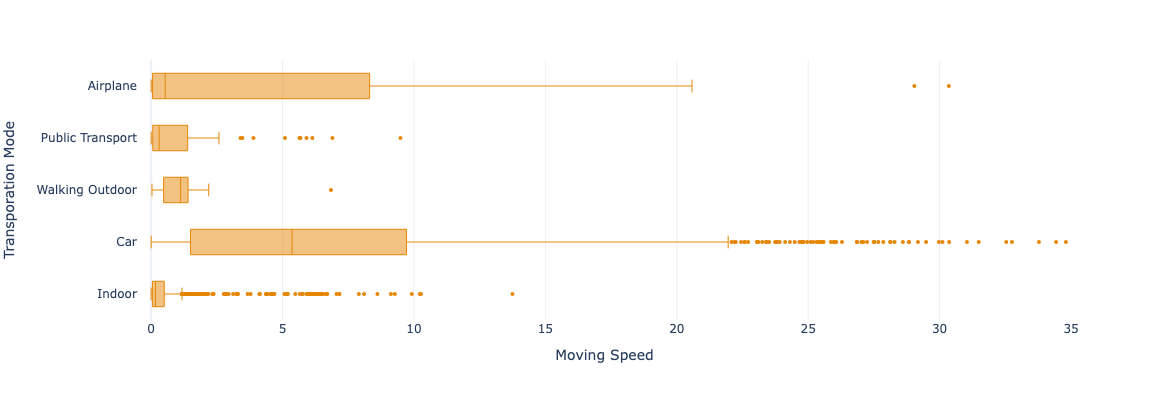

In [14]:
import plotly.express as px
fig = px.box(confidence, x='speed', y='movement', 
             range_x=(-0.5, 35), 
             color_discrete_sequence=px.colors.qualitative.Vivid, template='plotly_white')
fig.update_xaxes(title_text='Moving Speed')
fig.update_yaxes(title_text='Transporation Mode')
fig.update_layout(
    autosize=False,
    width=800,
    height=400)
fig.update_traces(line=dict(width=1), marker=dict(size=4))
fig

## Removal

In [15]:
def remove_outliners_with_movements(lats, lngs, all_images, limits={}, ignore=[]):
    assert len(lats) == len(lngs), "Different lengths of lats and lngs"
    i = 0
    to_remove = []
    speeds = [0.0]
    next_valid = []
    activities = []
    movement_valid = []
    j = i + 1
    key = ""
    while j < len(lats):
        dist = distance(lats[j], lngs[j], lats[i], lngs[i])
        accept = False
        if dist:
            time_dist = j-i
            speed = dist/time_dist/60
            if j in ignore:
                accept = True
            else:
                if not limits:
                    accept = True
                else:
                    if not isinstance(all_images[j], str): # No images available. Ok to cut
                        accept = True
                    else:
                        # Get movement mode from i -> j
                        images = []
                        for row in range(i, j+1):
                            if isinstance(all_images[row], str):
                                row_images = json.loads(all_images[row].replace("'", '"'))
                                if row_images:
                                    images.extend(row_images)
                        if images:
                            image_features = get_stop_embeddings(images) 
                            try:
                                image_features = torch.tensor(image_features).cuda().float()
                                movement, movement_prob = movement_mode(list(moves.keys()), image_features)
        #                         inside, inside_prob = movement_mode(list(insides.keys()), image_features)
        #                         key = f"{moves[movement]}_{insides[inside]}"
                                key = moves[movement]
                                if key in limits and speed < limits[key]:
                                    accept = True
                            except RuntimeError as e:
                                accept = False
        else:
            speed = None
            if np.isnan(lats[i]):
                accept = True
                
        if accept:
            # Acceptable distance
            speeds.append(speed)
            next_valid.extend([j for i in range(j-i)])
            activities.extend([key for i in range(j-i)])
            i = j
        else:
            # Delete that point and recalculate
            to_remove.append(j)
            speeds.append(speed)
        j += 1
    next_valid.extend([j for i in range(j-i)])
    activities.extend([key for i in range(j-i)])
    return to_remove, speeds, next_valid, activities

In [16]:
# [PAPER] If two consecutive data points is greater than 130km per hours, delete (130km/h = 2160m/minute)
gps = metadata.copy()
gps.loc[0,"latitude"] = 53.38998
gps.loc[0, "longitude"] = -6.1457602

In [ ]:
to_remove, speeds, next_valid, activities = remove_outliners_with_movements(gps["latitude"], gps["longitude"], gps["ImageID"], limits)

In [ ]:
gps["original_lat"] = gps["latitude"]
gps["original_lng"] = gps["longitude"]
gps.loc[to_remove, "latitude"] = np.nan
gps.loc[to_remove, "longitude"] = np.nan
gps['speed'] = speeds
gps['next_valid'] = next_valid
gps["activities"] = activities

In [ ]:
gps_drop = gps.groupby((gps['next_valid'].shift() != gps['next_valid']).cumsum()).agg(
                                                          images=('ImageID', unpack_str),
                                                          duration=('minute_id', 'count'),
                                                          num_images=('ImageID', count_unpack_str),
                                                          lat=('latitude', 'first'),
                                                          lng=('longitude', 'first'),
                                                          first_index=('index', 'first'),
                                                          last_index=('index', 'last'),
                                                          movement=('activities', 'last')
                                                        )
gps_drop = gps_drop.loc[gps_drop['duration'] > 1]
gps_drop = gps_drop.sort_values(by=['num_images'], ascending=[False])
gps_drop = gps_drop.reset_index()
gps_drop = gps_drop.drop(columns=['next_valid'])
gps_drop

## Test

In [24]:
def plot_images(images):
#     images = row["images"]
    plt.figure(figsize=(12, len(images)))
    k = 0
    for filename in images:
        image = Image.open("../../original_data/201901/"+ filename[6:8] + "/" + filename).convert("RGB")
        ax = plt.subplot(len(images) // 4 + 1, 4, k+1)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(filename)
        k += 1
    plt.tight_layout()

In [16]:
moves = {"I am sitting on an airplane": "Airplane",
         "I am driving a car": "Car",
         "I am on a bus": "Bus",
         "I am walking inside a building or a house": "Walking Inside",
         "I am walking outside": "Walking Outside",
        #  "I am cycling": "Cycling",
        #  "I am riding a motorbike": "Motorbike",
         "I am on a train": "Train",
         "I am in a parking lot": "Parking lot",
         "I am being still inside a building or a house": "Still"}

In [17]:
all_images = []
images = gps_drop.iloc[171]["images"]
if isinstance(images, str):
    images = json.loads(images.replace("'", '"'))
all_images.extend(images)

if all_images:
    image_features = get_stop_embeddings(all_images) 
try:
    image_features = torch.tensor(image_features).cuda().float()
except RuntimeError as e:
    pass
movement_mode(list(moves.keys()), image_features)

('I am being still inside a building or a house',
 array(0.8170705, dtype=float32))

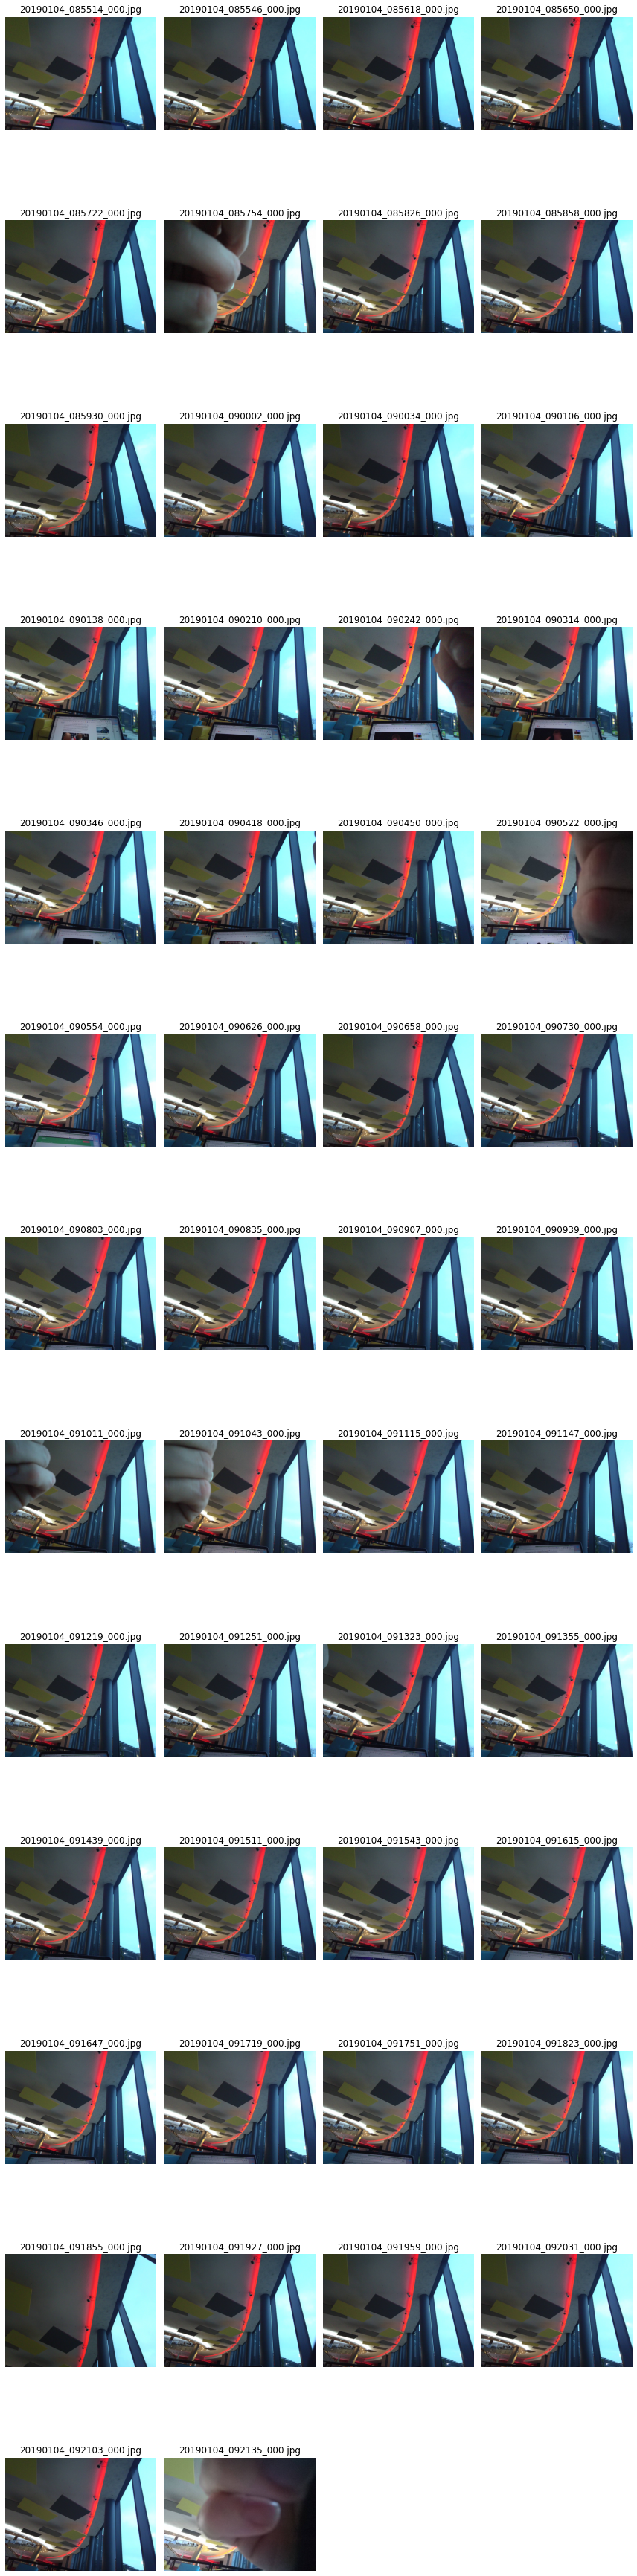

In [18]:
plot_images(all_images)

In [19]:
from ipyleaflet import Map, Polyline

row = gps_drop.iloc[3]
# start = row["index"]
# end = row["next_valid"]
start = 920
end = 940
print(start, end)
lats = gps.iloc[start:end]["latitude"].tolist()
lngs = gps.iloc[start:end]["longitude"].tolist()
lats = [c for c in lats if not np.isnan(c)]
lngs = [c for c in lngs if not np.isnan(c)]
print(lats)

m = Map(center=(lats[0], lngs[0]), zoom=16)

line = Polyline(
    locations=list(zip(lats, lngs)),
    color="green" ,
    fill=False
)
m.add_layer(line)
m

920 940
[53.34052439999999, 53.34018026, 53.33997610000001, 53.34114542, 53.3425632, 53.34262632, 53.34252179]


Map(center=[53.34052439999999, -6.2617356], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

# Gap Treatment

In [25]:
# # Forward fill for LatLon if Distance = 0.0 (known distance)
# last_lat = None
# last_lon = None
# for index, row in tqdm(gps.iterrows(), total=len(gps)):
#     if row["distance"] == 0.0:
#         if np.isnan(row["latitude"]):
#             gps.loc[index, "latitude"] = last_lat
#             gps.loc[index, "longitude"] = last_lon 
#     last_lat = gps.loc[index, "latitude"]
#     last_lon = gps.loc[index, "longitude"]

In [28]:
def list_all(series):
    return list(series.dropna())
def most_common(series):
    global count_none
    all_names = list(series.dropna())
    all_names = [",".join(name.split(',')[:2]) for name in all_names]
    if all_names:
        return Counter(all_names).most_common(1)[0][0]
    count_none += 1
    return np.nan

In [29]:
empty = gps.copy()
empty["ff_longitude"] = empty["longitude"].ffill(limit=1)
empty["ff_latitude"] = empty["latitude"].ffill(limit=1)
empty["bf_longitude"] = empty["longitude"].bfill(limit=1)
empty["bf_latitude"] = empty["latitude"].bfill(limit=1)

empty["longitude"][~empty["longitude"].isna()] = "valid"
empty["longitude"][empty["longitude"].isna()] = "nan"
empty = empty.groupby((empty['longitude'].shift() != empty['longitude']).cumsum()).agg(
                                                          minute_id=('minute_id', list_all),
                                                          valid=('longitude', 'first'),
                                                          duration=('minute_id', 'count'),
                                                          lat1=('ff_latitude', 'first'),
                                                          lng1=('ff_longitude', 'first'),
                                                          lat2=('bf_latitude', 'last'),
                                                          lng2=('bf_longitude', 'last'),
                                                          first_index=('index', 'first'),
                                                          last_index=('index', 'last'),
                                                          images=('ImageID', unpack_str),
                                                          movement=('movement', most_common)
                                                        )
empty = empty.reset_index()
empty = empty.drop(columns=['longitude'])
empty = empty.loc[empty['valid'].isin(['nan'])]
empty["distance"] = empty.progress_apply(lambda x: distance(x['lat1'], x['lng1'], x['lat2'], x['lng2']), axis=1)

  0%|          | 0/1389 [00:00<?, ?it/s]

In [30]:
MIN_PTS = 3
# empty = empty.loc[empty['duration'] > MIN_PTS]
empty

                                              minute_id valid  duration  \
1     [20190101_0001, 20190101_0002, 20190101_0003, ...   nan       451   
3     [20190101_0742, 20190101_0743, 20190101_0744, ...   nan         4   
5     [20190101_0748, 20190101_0749, 20190101_0750, ...   nan        38   
7     [20190101_0827, 20190101_0828, 20190101_0829, ...   nan        82   
9                        [20190101_0950, 20190101_0951]   nan         2   
...                                                 ...   ...       ...   
2769                     [20190131_2119, 20190131_2120]   nan         2   
2771                                    [20190131_2130]   nan         1   
2773  [20190131_2132, 20190131_2133, 20190131_2134, ...   nan        87   
2775  [20190131_2300, 20190131_2301, 20190131_2302, ...   nan        22   
2777  [20190131_2327, 20190131_2328, 20190131_2329, ...   nan        33   

           lat1      lng1       lat2      lng2  first_index  last_index  \
1     53.389980 -6.14576

In [31]:
# to_remove = []
for i, gap in empty.iterrows():
#     if gap["duration"] > MIN_PTS and row["distance"] > 50:
#         to_remove.append(row["last_index"] + 1)
    if gap["duration"] > MIN_PTS:
        interval = (gap["duration"] - 1) // (MIN_PTS + 1) + 1
        total_intervals = gap["duration"] / interval
        j = 0
        for i in range(gap["first_index"] + interval, gap["last_index"] + 1, interval):
            j += 1
            gps.loc[i, "latitude"] = gap["lat1"] + (gap["lat2"] - gap["lat1"]) * j / total_intervals
            gps.loc[i, "longitude"] = gap["lng1"] + (gap["lng2"] - gap["lng1"]) * j / total_intervals
    else:
        if gap["movement"] in ["Still", "Walking Inside"] and gap["distance"]/gap["duration"] < limits[gap["movement"]]:
            gps.loc[gap["first_index"]-1: gap["last_index"] + 1, "latitude"] = gps.loc[gap["first_index"]-1: gap["last_index"] + 1, "latitude"].interpolate()
            gps.loc[gap["first_index"]-1: gap["last_index"] + 1, "longitude"] = gps.loc[gap["first_index"]-1: gap["last_index"] + 1, "longitude"].interpolate()

# Save files

In [32]:
cleaned_gps = gps[['minute_id', 'latitude', 'longitude', 'ImageID', 'speed', 'movement', 'time_zone', 'original_lat', 'original_lng']]
cleaned_gps.to_csv('files/test/cleaned_gps.csv')
# cleaned_gps = cleaned_gps.dropna(subset=['latitude'])
cleaned_gps

           minute_id  latitude  longitude ImageID  speed movement time_zone  \
0      20190101_0000  53.38998   -6.14576     NaN    0.0      NaN       NaN   
1      20190101_0001       NaN        NaN     NaN    NaN      NaN       NaN   
2      20190101_0002       NaN        NaN     NaN    NaN      NaN       NaN   
3      20190101_0003       NaN        NaN     NaN    NaN      NaN       NaN   
4      20190101_0004       NaN        NaN     NaN    NaN      NaN       NaN   
...              ...       ...        ...     ...    ...      ...       ...   
44635  20190131_2355       NaN        NaN     NaN    NaN      NaN       NaN   
44636  20190131_2356       NaN        NaN     NaN    NaN      NaN       NaN   
44637  20190131_2357       NaN        NaN     NaN    NaN      NaN       NaN   
44638  20190131_2358       NaN        NaN     NaN    NaN      NaN       NaN   
44639  20190131_2359       NaN        NaN     NaN    NaN      NaN       NaN   

       original_lat  original_lng  
0          53.3